## Test ($\epsilon$,$\delta$)-differentially private synthetic data generation on simple dataset

In this notebook, we investigate the effect of enforcing differential privacy on usefulness of synthetic data. We firstly generate a simple dataset consisting of four independently unit-Gaussian distributed covariates $X$, and a Bernoulli-distributed outcome $Y$ with $E(Y)=logistic(\beta X)$

We make use of a public github library for [differentially private synthetic data generation](https://github.com/BorealisAI/private-data-generation)

Control parameters are as follows

In [1]:
############################################################
## File paths --------------------------------------------##
############################################################

# File paths for original and synthesised data sets
orig_path='/home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Original/'
synth_path='/home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/'

# File path containing evaluate.py and PDG repository
pdg_path='/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/'

# File path to which outputs will be saved. Should contain directories called Figures, Tables
output_path='/home/ec2-user/GRAIMatter/WP1/reports/synthetic_data/'

# Paths to scripts
spath1='/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/PATEGAN/'



############################################################
## Synth. generation methods and DP levels ---------------##
############################################################

# This parameter can be 'dp-wgan' or 'pate-gan' (GAN-based) or 'ron-gauss' (Gaussian projection)
#  Other options may be added. The parameter synth_extra governs extra parameters to be passed - 
#  see evaluate.py for details
#synth_method='dp-wgan'; synth_extra='--sigma=0.8'
#synth_method='ron-gauss'; synth_extra='';
synth_method='pate-gan'; synth_extra='';

# We will consider epsilon-DP for these epsilon levels
dp_levels=[1,5,100,10**6]

# This parameter controls whether output from the system call to evaluate.py is shown in the notebook
show_output=True



############################################################
## Data parameters ---------------------------------------##
############################################################

# Random seed
random_seed=38273

# Simulate this many points
nx=5000

# Number of covariates
p=4

# Parameters of Gaussian distribution for IID covariates
mu=0
sigma=1

# Coefficients of logistic model for Y
beta0=[0.5,1,-1,-0.5]
beta=tuple([10*x for x in beta0])


Preliminary set-up as follows

In [2]:
# Preliminaries
import os
import sys
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import csv
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

# Add requisite code paths to path
sys.path.insert(1, spath1)

# Code
from data_generator import data_generator
from pate_gan import pategan

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(random_seed)

Instructions for updating:
non-resource variables are not supported in the long term


Some functions which will be useful

In [3]:
# Basic functions
def logistic1(x):
  return 1/(1+math.exp(-x))
logistic=np.vectorize(logistic1)
def logit1(x):
  return math.log(x/(1-x))
logit=np.vectorize(logit1)

# Sensitivity and specificity at range of cutoffs
def roc_xy(ypred,y,res=0):
    yt=sum(y); yl=len(y)
    opred=np.argsort(ypred) 
    sy=y[opred]; sp=ypred[opred]

    sens=1- (np.cumsum(sy)/yt)
    spec=np.cumsum(1-sy)/(yl-yt)
    
    # coarsen; choose points regularly along arc length. Speeds up and privatises plot drawing
    if res>0:
       ds=np.cumsum(math.sqrt((spec[0:(yl-1)]-spec[1:yl])**2 + (sens[0:(yl-1)]-sens[1:yl])**2))
       ds=ds/ds[yl-1]
       lsp=list(range(1,yl-1))/yl
       sub=np.round(yl*np.interp(np.linspace(0,max(ds),num=res),ds,lsp))
       sens=sens[sub]
       spec=spec[sub]
    
    return np.column_stack((sens,spec))

# Return a system command to generate synthetic data
def syscom_synth(opath,spath,epath,train_name,test_name,target_name,model_type,extra,dp_e,dp_d):
    out="python "+ epath + "evaluate.py "+\
    "--train-data-path="+opath+train_name+" "+\
    "--test-data-path="+opath+test_name+" "+\
    "--target-variable="+target_name+" "+\
    model_type+" "+\
    "--save-synthetic --output-data-path="+spath+" "+\
    extra
    if dp_e>0:
        out=out+" --enable-privacy --target-epsilon="+str(dp_e)
    if dp_d>0:
        out=out+" --target-delta="+str(dp_d)
    return out


Now we generate basic data which we will try and mimic

In [4]:
# Generate covariate data - random
#cov_train=np.reshape(np.random.normal(mu,sigma,p*nx),(nx,p))
#cov_test=np.reshape(np.random.normal(mu,sigma,p*nx),(nx,p))

# Generate covariate data - uniform
cov_train=np.reshape(np.random.uniform(-0.5,0.5,p*nx),(nx,p))
cov_test=np.reshape(np.random.uniform(-0.5,0.5,p*nx),(nx,p))


# Generate outcome data
p_train=logistic(np.matmul(cov_train,beta))
p_test=logistic(np.matmul(cov_test,beta))
y_train=np.random.binomial(1,p_train,nx)
y_test=np.random.binomial(1,p_test,nx)

# Combine covariates and outcome
dat_train=np.column_stack((cov_train,y_train))
dat_test=np.column_stack((cov_test,y_test))

# Glimpse
#print(dat_train[-5:])
#print(dat_test[-5:])

# Column names
dat_colnames=["X1","X2","X3","X4","Y"]

# Write to file
with open(orig_path+'simple_logistic/simple_logistic_train.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(dat_colnames)
    writer.writerows(dat_train)
    f.close()
with open(orig_path+'simple_logistic/simple_logistic_test.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(dat_colnames)
    writer.writerows(dat_test)
    f.close()
    

Now we will generate some synthetic datasets

In [24]:
# Firstly with no differential privacy. 
if (synth_method in ['ron-gauss','dp-wgan']) 

    s0=syscom_synth(orig_path,synth_path,pdg_path,
             'simple_logistic/simple_logistic_train.csv','simple_logistic/simple_logistic_test.csv',
             'Y',synth_method,synth_extra,0,0)
    if show_output:
        os.system(s0)
    else:
        s0_out=os.popen(s0).read()
    s0_mv="mv "+synth_path+"synthetic_data.csv "+synth_path+"simple_logistic_0_"+synth_method+".csv"
    os.system(s0_mv)

if (synth_method=='pate-gan') 
    parameters = {'n_s': 1, 'batch_size': 64, 'k': 100, 
                'epsilon': 100, 'delta': 0.0001, 
                'lamda': 1}
    stemp=pategan(dat_train, parameters)
    stemp[:,stemp.shape[2]-1]=round(stemp[:,stemp.shape[2]-1])
    with open(synth_path+'simple_logistic_0_pate-gan.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(dat_colnames)
        writer.writerows(stemp)
        f.close()
    
# With differential privacy
for dp in dp_levels:
    print("Processing differential privacy level "+str(dp))
    sdp=syscom_synth(orig_path,synth_path,pdg_path,
             'simple_logistic/simple_logistic_train.csv','simple_logistic/simple_logistic_test.csv',
             'Y',synth_method,synth_extra,dp,0)
    if show_output:
        os.system(sdp)
    else:
        sdp_out=os.popen(sdp).read()
    sdp_mv="mv "+synth_path+"synthetic_data.csv "+synth_path+\
           "simple_logistic_"+str(dp)+"_"+synth_method+".csv"
    os.system(sdp_mv)


/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)
/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)


AUC scores of downstream classifiers on test data : 
----------------------------------------
LR: 0.5302473605463865
----------------------------------------
Random Forest: 0.5283651232961432
----------------------------------------
Neural Network: 0.5149908352971981
----------------------------------------
GaussianNB: 0.5029961343712528
----------------------------------------
GradientBoostingClassifier: 0.5046883873004044
Saved synthetic data at :  /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/
Processing differential privacy level 1


/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)
/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)


AUC scores of downstream classifiers on test data : 
----------------------------------------
LR: 0.5327903014844706
----------------------------------------
Random Forest: 0.4929264851908262
----------------------------------------
Neural Network: 0.506676340341786
----------------------------------------
GaussianNB: 0.5100083484264433
----------------------------------------
GradientBoostingClassifier: 0.4920835598100093
Saved synthetic data at :  /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/
Processing differential privacy level 5


/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)
/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)


AUC scores of downstream classifiers on test data : 
----------------------------------------
LR: 0.5210600901041056
----------------------------------------
Random Forest: 0.5210553685055612
----------------------------------------
Neural Network: 0.5099939435495281
----------------------------------------
GaussianNB: 0.5350337810369079
----------------------------------------
GradientBoostingClassifier: 0.4942687796380342
Saved synthetic data at :  /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/
Processing differential privacy level 100


/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)
/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)


AUC scores of downstream classifiers on test data : 
----------------------------------------
LR: 0.5482838669860067
----------------------------------------
Random Forest: 0.5133904534719275
----------------------------------------
Neural Network: 0.5169849504248158
----------------------------------------
GaussianNB: 0.5418533698769055
----------------------------------------
GradientBoostingClassifier: 0.517324665438731
Saved synthetic data at :  /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/
Processing differential privacy level 1000000


/home/ec2-user/GRAIMatter/WP1/models/Synthetic_data/models/ron_gauss.py:75: RuntimeWarning: covariance is not positive-semidefinite.
  synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)


AUC scores of downstream classifiers on test data : 
----------------------------------------
LR: 0.5240916764779884
----------------------------------------
Random Forest: 0.49626265468437003
----------------------------------------
Neural Network: 0.5110126884558036
----------------------------------------
GaussianNB: 0.5109219377312383
----------------------------------------
GradientBoostingClassifier: 0.5117060431979851
Saved synthetic data at :  /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/


We now read synthetic-datasets back in. We fit (M-open) models to
 - the test set
 - a synthetic dataset with no DP guarantee
 - DP-guaranteed synthetic datasets
 
and test them on the original test set

Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_0_ron-gauss.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_1_ron-gauss.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_5_ron-gauss.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_100_ron-gauss.csv
Loading /home/ec2-user/studies/GRAIMatter/data/Synthetic_generation/Synthetic/simple_logistic_1000000_ron-gauss.csv


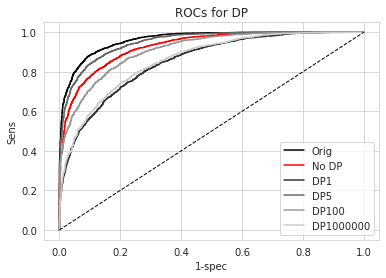

------------  ---------  --------  ----------  ---------
True           5         10        -10         -5
Orig.          4.45992    8.7797    -8.85289   -4.36927
Synth, no DP   0.407253   2.03792   -3.34355   -1.81237
DP 1           2.34575    1.32426    0.231387   3.0895
DP 5           2.55887    2.15936    2.73135    0.798331
DP 100        -0.299513  -2.8389    -4.72953   -2.77944
DP 1000000    -1.42371   -1.91522   -0.652408  -1.88998
------------  ---------  --------  ----------  ---------


In [25]:
## Model fitted to original training data
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(cov_train,y_train)
ypred_test_orig=model.predict_proba(cov_test)[:,1]
beta_orig=model.coef_

## Model fitted to synthetic dataset with no DP guarantee
# Read in
s0_path=synth_path+"simple_logistic_0_"+synth_method+".csv"
print("Loading "+s0_path)
synth0 = np.loadtxt(s0_path, delimiter=",",skiprows=1)[:,1:]
# Fit model
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(synth0[:,0:p],synth0[:,p:(p+1)])
ypred_test_0=model.predict_proba(cov_test)[:,1]
beta_0=model.coef_

# Models fitted to DP datasets
ypred_test_dp=np.zeros([nx,len(dp_levels)])
beta_dp=np.zeros([p,len(dp_levels)])
for i in list(range(0,len(dp_levels))):
    dp=dp_levels[i]
    sdp=synth_path+"simple_logistic_"+str(dp)+"_"+synth_method+".csv"
    print("Loading "+sdp)
    synthd = np.loadtxt(sdp, delimiter=",",skiprows=1)[:,1:]
    # Fit model
    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(synthd[:,0:p],synthd[:,p:(p+1)])
    ypred_test_d=model.predict_proba(cov_test)[:,1]
    ypred_test_dp[:,i]=ypred_test_d
    beta_dp[:,i]=model.coef_

## Plot ROC curves

# Original data
ss_orig=roc_xy(ypred_test_orig,y_test)
plt.plot(1-ss_orig[:,1],ss_orig[:,0],label="Orig",color="black")

# No DP
ss_0=roc_xy(ypred_test_0,y_test)
plt.plot(1-ss_0[:,1],ss_0[:,0],label="No DP",color="red")

# DP levels
for i in list(range(0,len(dp_levels))):
    ss_dp=roc_xy(ypred_test_dp[:,i],y_test)
    plt.plot(1-ss_dp[:,1],ss_dp[:,0],
             label="DP"+str(dp_levels[i]),
             color=str((i+1)/(len(dp_levels)+1)))

# X-Y line
plt.plot([0,1],[0,1],linestyle="--",linewidth=1,color="black")

# Draw plot
plt.title('ROCs for DP')
plt.xlabel('1-spec')
plt.ylabel('Sens')
plt.legend()

# Save figure
plt.savefig(output_path+'Figures/DP_ROC_'+synth_method+"_"+str(nx)+'.pdf', bbox_inches='tight')

# Show figure
plt.show()

# Print betas
btab=np.concatenate(
    (np.reshape(np.array(beta),(1,p)),
     beta_orig,
     beta_0,
     beta_dp))
rindex=["True","Orig.","Synth, no DP"] + ["DP "+str(d) for d in dp_levels]
print(tabulate(btab,showindex=rindex))

# Write to table
with open(output_path+'Tables/DP_beta_'+synth_method+'_'+str(nx)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(rindex)
    writer.writerows(np.transpose(btab))
    f.close()



Check densities of original and synthesised variables

<AxesSubplot:ylabel='Density'>

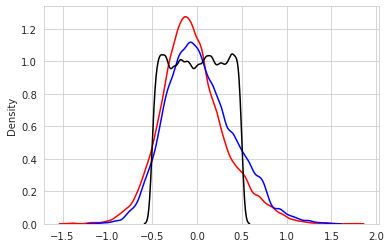

In [26]:
sns.set_style('whitegrid'); bwx=0.1
sns.kdeplot(np.array(synth0[:,0]), bw=bwx,color="red")
sns.kdeplot(np.array(synthd[:,0]), bw=bwx,color="blue")
sns.kdeplot(cov_train[:,1], bw=bwx,color="black")